<h1> Sparse barycenters simulations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import random as random
from matplotlib.patches import Ellipse
from matplotlib import colors
from ot.backend import get_backend
import pandas as pd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h4> Useful functions

In [15]:
def random_covariance(dim=2):
    A = np.random.randn(dim, dim)
    return np.dot(A, A.T) + 0.1 * np.eye(dim)
def random_gaussians(dim=2,n_gauss=5):
    m = [np.random.uniform(-1, 1, size=dim) for _ in range(n_gauss)]
    C = [random_covariance(dim) for _ in range(n_gauss)]
    return m,C
#modification of ot.free_support_barycenter to optimize D=W_eps,2^2
#(X_inf, weights_inf, Y_ref, weight_ref,1)
def free_support_barycenter_entropic(
    measures_locations,
    measures_weights,
    X_init,
    reg,
    b=None,
    weights=None,
    numItermax=2000,
    stopThr=1e-7,
    verbose=False,
    log=None
):
    nx = get_backend(*measures_locations, *measures_weights, X_init)

    iter_count = 0

    N = len(measures_locations)
    k = X_init.shape[0]
    d = X_init.shape[1]
    if b is None:
        b = nx.ones((k,), type_as=X_init) / k
    if weights is None:
        weights = nx.ones((N,), type_as=X_init) / N

    X = X_init

    log_dict = {}
    displacement_square_norms = []

    displacement_square_norm = stopThr + 1.0

    while displacement_square_norm > stopThr and iter_count < numItermax:
        T_sum = nx.zeros((k, d), type_as=X_init)

        for measure_locations_i, measure_weights_i, weight_i in zip(
            measures_locations, measures_weights, weights
        ):
            M_i = ot.dist(X, measure_locations_i)
            T_i = ot.sinkhorn(b, measure_weights_i, M_i, reg,numItermax=2000)
            T_sum = T_sum + weight_i * 1.0 / b[:, None] * nx.dot(
                T_i, measure_locations_i
            )

        displacement_square_norm = nx.sum((T_sum - X) ** 2)
        if log:
            displacement_square_norms.append(displacement_square_norm)

        X = T_sum
        if verbose:
            print(
                "iteration %d, displacement_square_norm=%f\n",
                iter_count,
                displacement_square_norm,
            )

        iter_count += 1

    if log:
        log_dict["displacement_square_norms"] = displacement_square_norms
        return X, log_dict
    else:
        return X


**Comments:**

-The more spread out the target measures' supports are, the more unstable the barycenter algorithm becomes


<h2> Evolution of the estimation error with increasing $n$

This part is devoted to the study of the evolution of $\mathbb{E}\left[F_\mathbb{D}(\mu^1,\ldots,\mu^L,\nu_n)-F_\mathbb{D}(\mu^1,\ldots,\mu^L,\nu^*)\right]$ as $n$ varies.

<h3>$\mathbb{D}=W_{2}^2$

code

In [49]:
def simulation_Wasserstein_bary_gaussians_random(n_inf, n_points, N, n_gauss=5, nb_exp=10):
    # Establishing the gaussian target measures and their weight:
    m, C = random_gaussians(2, n_gauss)
    X_inf = [np.random.multivariate_normal(m[i], C[i], n_inf) for i in range(n_gauss)]
    weights_inf = [np.ones(n_inf) / n_inf for _ in range(n_gauss)]
    Y_0 = np.random.normal(0.0, 1.0, (N, 2))
    weight_bary = np.ones(N) / N
    
    W_all = np.zeros((nb_exp, len(n_points)))
    
    #Clever initialisation
    n_c=3000
    X_c = [np.random.multivariate_normal(m[i], C[i], n_c) for i in range(n_gauss)]
    weights_c = [np.ones(n_c) / n_c for _ in range(n_gauss)]
    Y_0=ot.lp.free_support_barycenter(X_inf, weights_inf, Y_0, b=weight_bary,numItermax=2000)
    
    #Computation of the "true" barycenter
    real_bary=ot.lp.free_support_barycenter(X_inf, weights_inf, Y_0, weight_bary,numItermax=1500)
    M_list = [ot.dist(X_inf[i], real_bary, metric="sqeuclidean") for i in range(n_gauss)]
    #Computation of the "true" barycenter loss
    FD_min = np.mean([ot.emd2(weights_inf[i], weight_bary, M_list[i]) for i in range(n_gauss)])
    FD_min_all=[FD_min for k in range(nb_exp)]
    
    #We do several experiments
    for exp in range(nb_exp):
        print(f"Experiment {exp+1}/{nb_exp}")
        W = np.zeros(len(n_points))
        for idx_n, n in enumerate(n_points):
            #sampling of the target measures
            samples = [np.random.multivariate_normal(m[i], C[i], n) for i in range(n_gauss)]
            weights = [np.ones(n) / n for _ in range(n_gauss)]
            #Computation of the empirical barycenter
            S = ot.lp.free_support_barycenter(samples, weights, Y_0, weight_bary,numItermax=1000)
            # Computation of the loss function evaluated in the empirical barycenter
            M_list = [ot.dist(X_inf[i], S, metric="sqeuclidean") for i in range(n_gauss)]
            W[idx_n] = np.mean([ot.emd2(weights_inf[i], weight_bary, M_list[i]) for i in range(n_gauss)])
        W_all[exp, :] = W

    return W_all, np.array(FD_min_all)

$L=3,\:N=10$

Expérience 1/20
Expérience 2/20
Expérience 3/20
Expérience 4/20
Expérience 5/20
Expérience 6/20
Expérience 7/20
Expérience 8/20
Expérience 9/20
Expérience 10/20
Expérience 11/20
Expérience 12/20
Expérience 13/20
Expérience 14/20
Expérience 15/20
Expérience 16/20
Expérience 17/20
Expérience 18/20
Expérience 19/20
Expérience 20/20


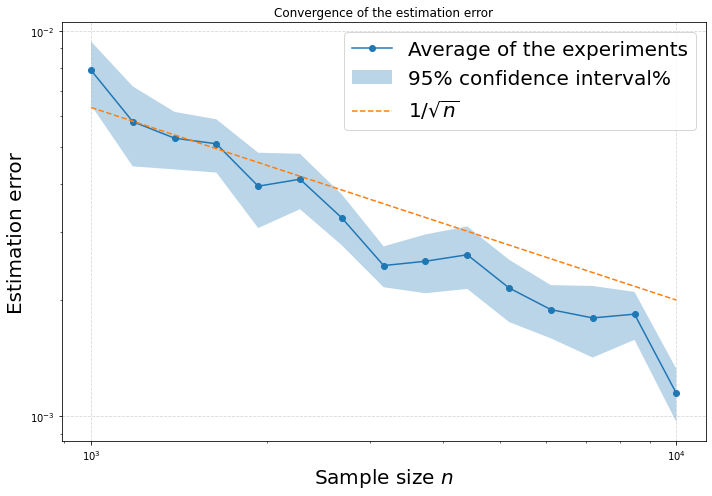

Résultats sauvegardés


In [24]:
N = 10
n_inf = 20000
n_gauss = 3
nb_exp = 20
n_points = np.unique(np.logspace(np.log10(1000), np.log10(10000), num=15, dtype=int))

W_all1, FD_min_all1 = simulation_Wasserstein_bary_gaussians_random(n_inf, n_points, N, n_gauss, nb_exp)
W_delta = W_all1 - FD_min_all1[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(n_points, mean_curve, "-o", label="Average of the experiments")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% confidence interval%")
plt.plot(n_points, 0.2 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.plot(n_points, 10 / (n_points), "--", label="$1/{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
plt.legend(fontsize=20, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("nvariesN10L3.pdf", dpi=300)
plt.show()
 #CSV
df = pd.DataFrame(W_all1, columns=[f"n={n}" for n in n_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df["FD_min"] = FD_min_all1
df.to_csv("df_nvariesN10L3.csv", index=False)
print("Results saved")

$L=3,\:N=50$

/home/lportale/.local/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Expérience 1/20
Expérience 2/20
Expérience 3/20
Expérience 4/20
Expérience 5/20
Expérience 6/20
Expérience 7/20
Expérience 8/20
Expérience 9/20
Expérience 10/20
Expérience 11/20
Expérience 12/20
Expérience 13/20
Expérience 14/20
Expérience 15/20
Expérience 16/20
Expérience 17/20
Expérience 18/20
Expérience 19/20
Expérience 20/20


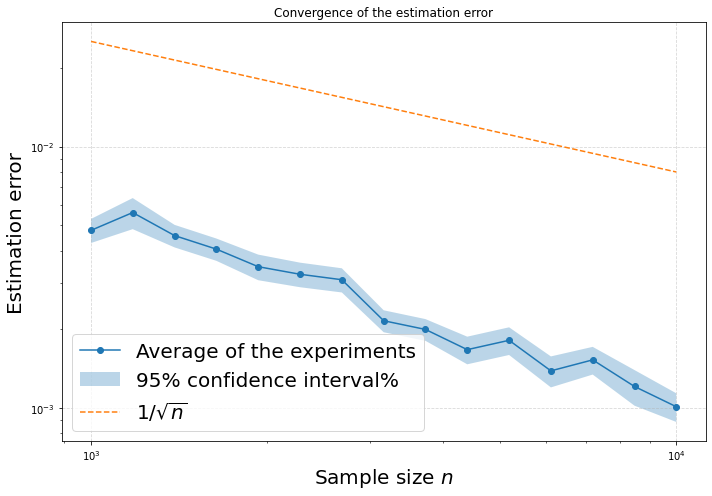

Résultats sauvegardés


In [50]:
N = 50
n_inf = 20000
n_gauss = 3
nb_exp = 20
n_points = np.unique(np.logspace(np.log10(1000), np.log10(10000), num=15, dtype=int))

W_all2, FD_min_all2 = simulation_Wasserstein_bary_gaussians_random(n_inf, n_points, N, n_gauss, nb_exp)
W_delta = W_all2 - FD_min_all2[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(n_points, mean_curve, "-o", label="Average of the experiments")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% confidence interval%")
plt.plot(n_points, 0.8 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=20)
plt.ylabel("Estimation error", fontsize=20)
plt.title("Convergence of the estimation error")
plt.legend(fontsize=20); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_nvariesN50L3.png", dpi=300)
plt.show()
df = pd.DataFrame(W_all1, columns=[f"n={n}" for n in n_points])
df.insert(0, "Experience", np.arange(1, nb_exp + 1))
df["FD_min"] = FD_min_all1
df.to_csv("df_nvariesN50L3.csv", index=False)
print("Results saved")


<h3> $\mathbb{D}=W_{\epsilon,2}^2,\:\epsilon=1$

Code

In [52]:
def simulation_Wasserstein_bary_gaussians_random_entropic(n_inf, n_points, N, n_gauss=5, nb_exp=10,reg=1):
    # Establishing the gaussian target measures and their weight:
    m, C = random_gaussians(2, n_gauss)
    X_inf = [np.random.multivariate_normal(m[i], C[i], n_inf) for i in range(n_gauss)]
    weights_inf = [np.ones(n_inf) / n_inf for _ in range(n_gauss)]
    Y_0 = np.random.normal(0.0, 1.0, (N, 2))
    weight_bary = np.ones(N) / N
    W_all = np.zeros((nb_exp, len(n_points)))

    #Clever initialisation
    n_c=3000
    X_c = [np.random.multivariate_normal(m[i], C[i], n_c) for i in range(n_gauss)]
    weights_c = [np.ones(n_c) / n_c for _ in range(n_gauss)]
    Y_0=free_support_barycenter_entropic(X_inf, weights_inf, Y_0, b=weight_bary,reg=reg,numItermax=2000)
    
    #Computation of the "true" barycenter
    real_bary=free_support_barycenter_entropic(X_inf, weights_inf, Y_0, b=weight_bary,reg=reg,numItermax=2000)
    M_list = [ot.dist(X_inf[i], real_bary, metric="sqeuclidean") for i in range(n_gauss)]
    #Computation of the "true" barycenter loss
    FD_min = np.mean([ot.sinkhorn2(weights_inf[i], weight_bary, M_list[i],reg) for i in range(n_gauss)])
    FD_min_all=[FD_min for k in range(nb_exp)]
    
    #We do several experiments
    for exp in range(nb_exp):
        print(f"Experiment {exp+1}/{nb_exp}")
        W = np.zeros(len(n_points))
        for idx_n, n in enumerate(n_points):
            #sampling of the target measures
            samples = [np.random.multivariate_normal(m[i], C[i], n) for i in range(n_gauss)]
            weights = [np.ones(n) / n for _ in range(n_gauss)]
            #Computation of the empirical barycenter
            S = free_support_barycenter_entropic(samples,weights,Y_0,b=weight_bary,reg=reg,numItermax=1000)
            # Computation of the loss function evaluated in the empirical barycenter
            M_list = [ot.dist(X_inf[i], S, metric="sqeuclidean") for i in range(n_gauss)]
            W[idx_n] = np.mean([ot.sinkhorn2(weights_inf[i], weight_bary, M_list[i],reg) for i in range(n_gauss)])
        W_all[exp, :] = W

    return W_all, np.array(FD_min_all)

$L=3,\:N=10,\:\epsilon=1$

Expérience 1/40
Expérience 2/40
Expérience 3/40
Expérience 4/40
Expérience 5/40
Expérience 6/40
Expérience 7/40
Expérience 8/40
Expérience 9/40
Expérience 10/40
Expérience 11/40
Expérience 12/40
Expérience 13/40
Expérience 14/40
Expérience 15/40
Expérience 16/40
Expérience 17/40
Expérience 18/40
Expérience 19/40
Expérience 20/40
Expérience 21/40
Expérience 22/40
Expérience 23/40
Expérience 24/40
Expérience 25/40
Expérience 26/40
Expérience 27/40
Expérience 28/40
Expérience 29/40
Expérience 30/40
Expérience 31/40
Expérience 32/40
Expérience 33/40
Expérience 34/40
Expérience 35/40
Expérience 36/40
Expérience 37/40
Expérience 38/40
Expérience 39/40
Expérience 40/40


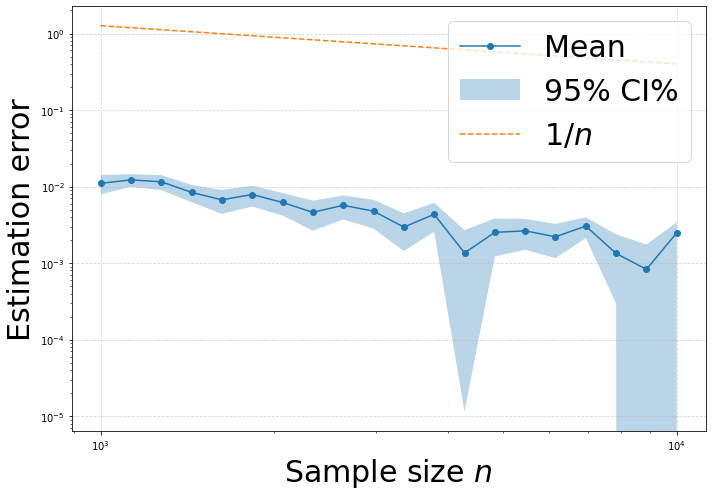

Résultats sauvegardés


In [53]:
N = 10
n_inf = 20000
n_gauss = 3
nb_exp = 40
n_points = np.unique(np.logspace(np.log10(1000), np.log10(10000), num=20, dtype=int))

W_all3, FD_min_all3 = simulation_Wasserstein_bary_gaussians_random_entropic(n_inf, n_points, N, n_gauss, nb_exp,1)
W_delta = W_all3 - FD_min_all3[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(n_points, mean_curve, "-o", label="Mean")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% CI%")
plt.plot(n_points, 40 / np.sqrt(n_points), "--", label="$1/n$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
plt.legend(fontsize=30, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_nvaries_regN10L3.pdf", dpi=300)
plt.show()

df = pd.DataFrame(W_all3, columns=[f"n={n}" for n in n_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df["FD_min"] = FD_min_all3
df.to_csv("df_nvariesN10L3eps1.csv", index=False)
print("Results saved")


$L=3,\:N=50,\:\epsilon=1$

Expérience 1/40
Expérience 2/40
Expérience 3/40
Expérience 4/40
Expérience 5/40
Expérience 6/40
Expérience 7/40
Expérience 8/40
Expérience 9/40
Expérience 10/40
Expérience 11/40
Expérience 12/40
Expérience 13/40
Expérience 14/40
Expérience 15/40
Expérience 16/40
Expérience 17/40
Expérience 18/40
Expérience 19/40
Expérience 20/40
Expérience 21/40
Expérience 22/40
Expérience 23/40
Expérience 24/40
Expérience 25/40
Expérience 26/40
Expérience 27/40
Expérience 28/40
Expérience 29/40
Expérience 30/40
Expérience 31/40
Expérience 32/40
Expérience 33/40
Expérience 34/40
Expérience 35/40
Expérience 36/40
Expérience 37/40
Expérience 38/40
Expérience 39/40
Expérience 40/40


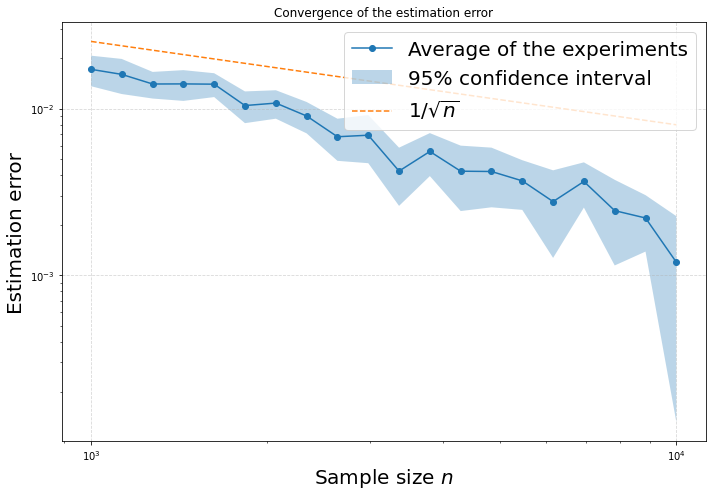

Résultats sauvegardés


In [71]:
N = 50
n_inf = 20000
n_gauss = 3
nb_exp = 40
n_points = np.unique(np.logspace(np.log10(1000), np.log10(10000), num=20, dtype=int))

W_all4, FD_min_all4 = simulation_Wasserstein_bary_gaussians_random_entropic(n_inf, n_points, N, n_gauss, nb_exp,1)
W_delta = W_all4 - FD_min_all4[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(n_points, mean_curve, "-o", label="Average of the experiments")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% confidence interval")
plt.plot(n_points, 0.8 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=20)
plt.ylabel("Estimation error", fontsize=20)
plt.title("Convergence of the estimation error")
plt.legend(fontsize=20, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_nvaries_regN50L3.pdf", dpi=300)
plt.show()
df = pd.DataFrame(W_all3, columns=[f"n={n}" for n in n_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df["FD_min"] = FD_min_all3
df.to_csv("df_nvariesN50L3eps1.csv", index=False)
print("Results saved")


<h2> Evolution of the functional as $N$ varies

<h3>$\mathbb{D}=W_{2}^2$

code

In [12]:
def simulation_Wasserstein_bary_gaussians_varyN(n_inf, n, N_points, n_gauss=5, nb_exp=10, dim=2):
    
    m, C = random_gaussians(dim, n_gauss)
    X_inf = [np.random.multivariate_normal(m[i], C[i], n_inf) for i in range(n_gauss)]
    weights_inf = [np.ones(n_inf) / n_inf for _ in range(n_gauss)]


    W_all_true = np.zeros((nb_exp, len(N_points)))
    W_all_emp = np.zeros((nb_exp, len(N_points)))


    real_bary_all = [[] for _ in range(len(N_points))]
    emp_bary_all = [[] for _ in range(len(N_points))]

    for exp in range(nb_exp):
        print(f"Experiment {exp+1}/{nb_exp}")
        samples = [np.random.multivariate_normal(m[i], C[i], n) for i in range(n_gauss)]
        weights = [np.ones(n) / n for _ in range(n_gauss)]
     
        for idx_N, N in enumerate(N_points):
            print(f"N =  {N}")
        
            Y_ref = np.random.normal(0.0, 1.0, (N, dim))
            weight_ref = np.ones(N) / N
        
            real_bary = ot.lp.free_support_barycenter(X_inf, weights_inf, Y_ref, weight_ref, numItermax=1000)
            real_bary_all[idx_N].append(real_bary)
        
        #computation of the "true" barycenter loss
            M_list = [ot.dist(X_inf[i], real_bary, metric="sqeuclidean") for i in range(n_gauss)]
            FD_min = np.mean([ot.emd2(weights_inf[i], weight_ref, M_list[i]) for i in range(n_gauss)])
            W_all_true[exp, idx_N] = FD_min
        
        #computation of the empirical barycenter
            emp_bary = ot.lp.free_support_barycenter(samples, weights, Y_ref, weight_ref, numItermax=1000)
            emp_bary_all[idx_N].append(emp_bary)
        
        #computation of the barycenter loss evaluated in the empirical barycenter
            M_list = [ot.dist(X_inf[i], emp_bary, metric="sqeuclidean") for i in range(n_gauss)]
            min_emp = np.mean([ot.emd2(weights_inf[i], weight_ref, M_list[i]) for i in range(n_gauss)])
            W_all_emp[exp,idx_N] = min_emp
        
    error = (W_all_emp-W_all_true)
        
    return error

def simulation_Wasserstein_bary_gaussians_varyN_reg(n_inf, n, N_points, n_gauss=5, nb_exp=10, dim=2,reg=1):
    #n_c=int(n_inf/2)
    m, C = random_gaussians(dim, n_gauss)
    X_inf = [np.random.multivariate_normal(m[i], C[i], n_inf) for i in range(n_gauss)]
    weights_inf = [np.ones(n_inf) / n_inf for _ in range(n_gauss)]


    W_all_true = np.zeros((nb_exp, len(N_points)))
    W_all_emp = np.zeros((nb_exp, len(N_points)))


    real_bary_all = [[] for _ in range(len(N_points))]
    emp_bary_all = [[] for _ in range(len(N_points))]

    for exp in range(nb_exp):
        print(f"Experiment {exp+1}/{nb_exp}")
        samples = [np.random.multivariate_normal(m[i], C[i], n) for i in range(n_gauss)]
        weights = [np.ones(n) / n for _ in range(n_gauss)]
     
        for idx_N, N in enumerate(N_points):
            print(f"N =  {N}")
            #X_c = [np.random.multivariate_normal(m[i], C[i], n_c) for i in range(n_gauss)]
            #weights_c = [np.ones(n_c) / n_c for _ in range(n_gauss)]
            weight_ref = np.ones(N) / N
            Y_ref = np.random.normal(0.0, 1.0, (N, dim))
            #Y_ref=free_support_barycenter_entropic(X_c, weights_c,reg, Y_ref,b=weight_ref)
            real_bary =ot.bregman.free_support_sinkhorn_barycenter(X_inf,weights_inf,Y_ref,reg=reg)
        #computation of the "true" barycenter loss
            M_list = [ot.dist(X_inf[i], real_bary, metric="sqeuclidean") for i in range(n_gauss)]
            FD_min = np.mean([ot.sinkhorn2(weights_inf[i], weight_ref, M_list[i],reg=reg) for i in range(n_gauss)])
            W_all_true[exp, idx_N] = FD_min

            
        #computation of the empirical barycenter
            emp_bary = ot.bregman.free_support_sinkhorn_barycenter(samples, weights, Y_ref,reg=reg)
        
        #computation of the barycenter loss evaluated in the empirical barycenter
            M_list = [ot.dist(X_inf[i], emp_bary, metric="sqeuclidean") for i in range(n_gauss)]
            min_emp = np.mean([ot.sinkhorn2(weights_inf[i], weight_ref, M_list[i],reg=reg) for i in range(n_gauss)])
            W_all_emp[exp,idx_N] = min_emp
    error = (W_all_emp-W_all_true)
        
    return error



Simulation in dimension $6$

Expérience 1/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 2/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 3/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 4/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 5/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 6/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 7/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 8/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 9/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
Expérience 10/10
N =  10
N =  17
N =  30
N =  53
N =  93
N =  163
N =  285
N =  499
[ 4.21797881  5.94332721  8.36449646 11.83961675 15.81179402 21.46669827
 26.58082263 34.73436111]
[ 4.93047333  6.27325566  8.9939396  12.33320561 16.42922024 21.846264

NameError: name 'LogLocator' is not defined

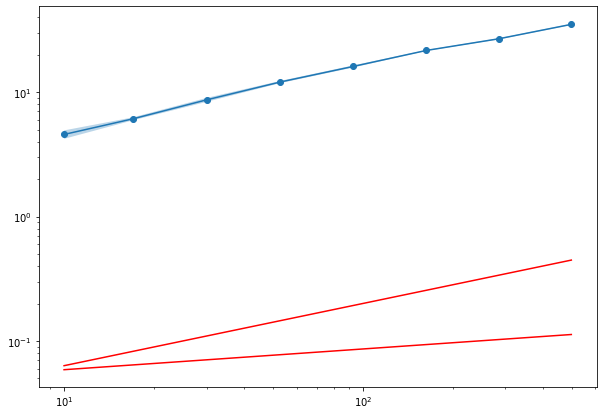

In [17]:
n_inf = 2000
n = 500
n_gauss = 5
nb_exp = 10
N_points =np.unique(np.logspace(np.log10(10), np.log10(500), num=8, dtype=int))
dim = 6



# >>> dimension 6 <<<
W_all5 = simulation_Wasserstein_bary_gaussians_varyN(n_inf, n, N_points, n_gauss, nb_exp, dim=20)

# Average + 95%IC
mean_curve = W_all5.mean(axis=0)
std_curve = W_all5.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
print(low)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)
print(up)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(N_points, mean_curve, "-o", label="Average of the experiments")
plt.fill_between(N_points, low, up, alpha=0.3, label="95% Confidence interval")
plt.plot(N_points, 0.2*0.1*np.sqrt(N_points), color = 'red', label = 'upper bound')
plt.plot(N_points, 0.2*0.2*np.sqrt(N_points**(1-4/dim)), color = 'red', label = 'lower bound')
plt.xscale("log"); plt.yscale("log")
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=10))
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=10))
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("Support size $N$", fontsize=16)
plt.ylabel("Estimation error", fontsize=16)
plt.title("Evolution of the estimation error with N",fontsize=16)
plt.legend(fontsize=16); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_W_varyN.pdf", dpi=300)
plt.show()
df = pd.DataFrame(W_all5, columns=[f"N={N}" for N in N_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df.to_csv("df_Nvaries.csv", index=False)
print("Results saved")


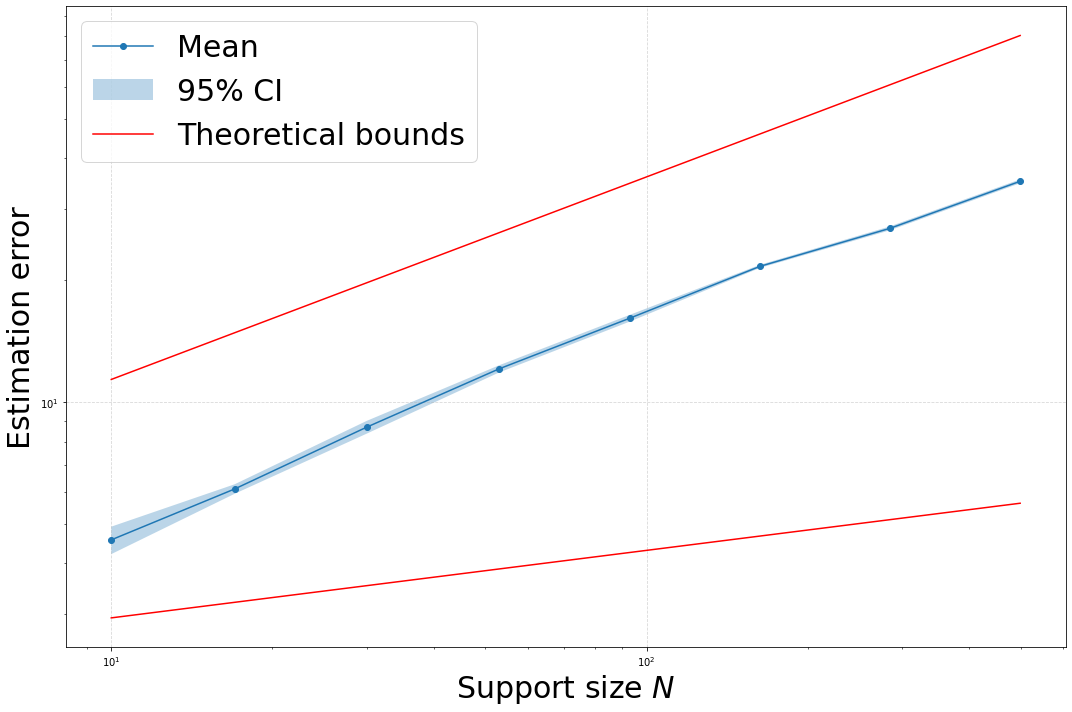

Résultats sauvegardés


In [25]:
# Plot
plt.figure(figsize=(15, 10))
plt.plot(N_points, mean_curve, "-o", label="Mean")
plt.fill_between(N_points, low, up, alpha=0.3, label="95% CI")
plt.plot(N_points, 3.6*np.sqrt(N_points), color = 'red', label = 'Theoretical bounds')
plt.plot(N_points, 2*np.sqrt(N_points**(1-4/dim)), color = 'red')
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Support size $N$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
plt.legend(fontsize=30,loc="upper left"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_W_varyN.pdf", dpi=300)
plt.show()
df = pd.DataFrame(W_all5, columns=[f"N={N}" for N in N_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df.to_csv("df_Nvaries.csv", index=False)
print("Results saved")


<h3>$\mathbb{D}=W_{\epsilon,2}^2$

code

Simulation in dimension 6

In [ ]:
n_inf = 10000
n = 500
n_gauss = 3
nb_exp = 10
N_points =np.unique(np.logspace(np.log10(10), np.log10(500), num=8, dtype=int))
reg=1
dim = 6


# >>> dimension 6 <<<
W_all6 = simulation_Wasserstein_bary_gaussians_varyN_reg(n_inf, n, N_points, n_gauss, nb_exp, dim=dim,reg=reg)
print(W_all6)
# Average + 95%IC
mean_curve = W_all6.mean(axis=0)
std_curve = W_all6.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
print(low)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)
print(up)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(N_points, mean_curve, "-o", label="Mean")
plt.fill_between(N_points, low, up, alpha=0.3, label="95% CI")
plt.plot(N_points, 0.2*np.sqrt(N_points), color = 'red', label = 'UB')
plt.plot(N_points, 0.09*np.sqrt(N_points**(1-4/dim)), color = 'red', label = 'LB')
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Support size $N$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
plt.legend(fontsize=30); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("evolution_W_varyNreg.pdf", dpi=300)
plt.show()
df = pd.DataFrame(W_all6, columns=[f"N={N}" for N in N_points])
df.insert(0, "Experiment", np.arange(1, nb_exp + 1))
df.to_csv("df_Nvaries_reg.csv", index=False)
print("Results saved")


<h2> Adjusting the figures from the dataframes

In [90]:
df1=pd.read_csv("df_nvariesN10L3.csv")
df2 = pd.read_csv("df_nvariesN50L3.csv")
df3=pd.read_csv("df_nvariesN10L3eps1.csv")
df4=pd.read_csv("df_nvariesN50L3eps1.csv")
df5=pd.read_csv("df_nvariesN10L3eps1version4.csv")
df6 = pd.read_csv("df_Nvaries_reg.csv")


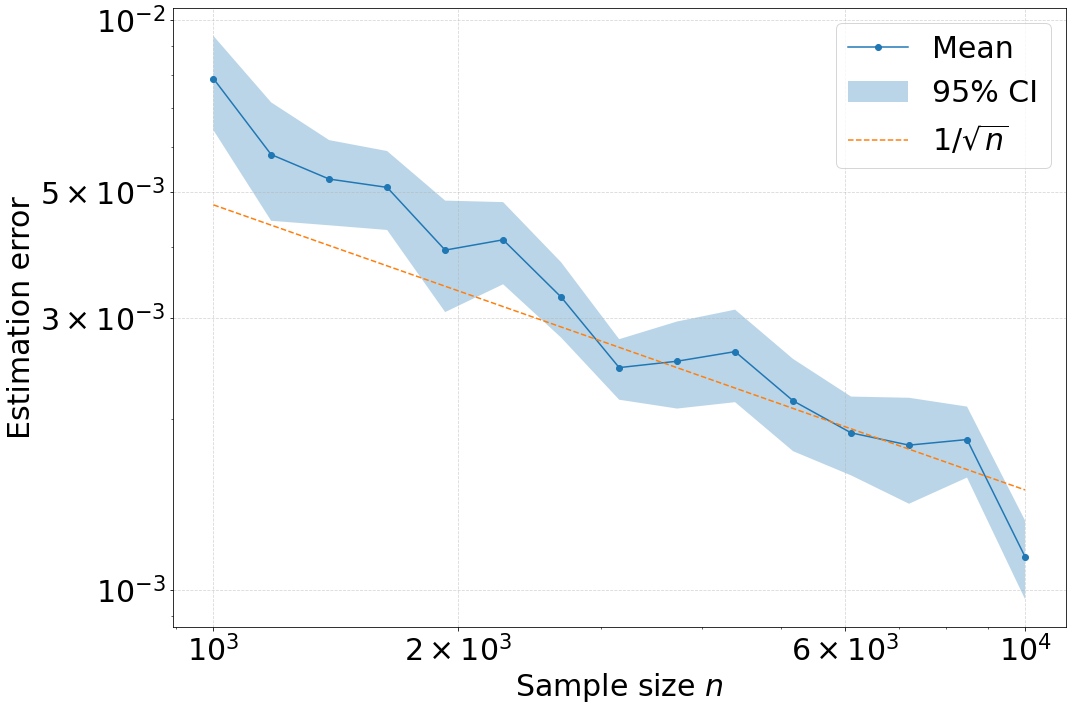

In [85]:
n_cols = [col for col in df1.columns if col.startswith("n=")]
n_points = np.array([int(col.split("=")[1]) for col in n_cols])
nb_exp=df1.shape[0]

W_all1 = df1[n_cols].values  # shape (nb_exp, len(n_points))


FD_min_all1 = df1["FD_min"].values  # shape (nb_exp,)
# Plot
W_delta = W_all1 - FD_min_all1[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

plt.figure(figsize=(15, 10))
plt.plot(n_points, mean_curve, "-o", label="Mean")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% CI")
plt.plot(n_points, 0.15 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
yticks = [0.001,0.003, 0.005, 0.01]
ytick_labels = [r"$10^{-3}$",r"$3\times 10^{-3}$", r"$5\times10^{-3}$", r"$10^{-2}$"]  # labels affichés
xticks=[1000,2000,6000,10000]
xticks_labels=[r"$10^3$",r"$2\times 10^{3}$",r"$6\times 10^{3}$",r"$10^4$"]
plt.yticks(yticks, ytick_labels,fontsize=30)
plt.xticks(xticks,xticks_labels,fontsize=30)
plt.legend(fontsize=30, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figure_N10.pdf", dpi=300)
plt.show()

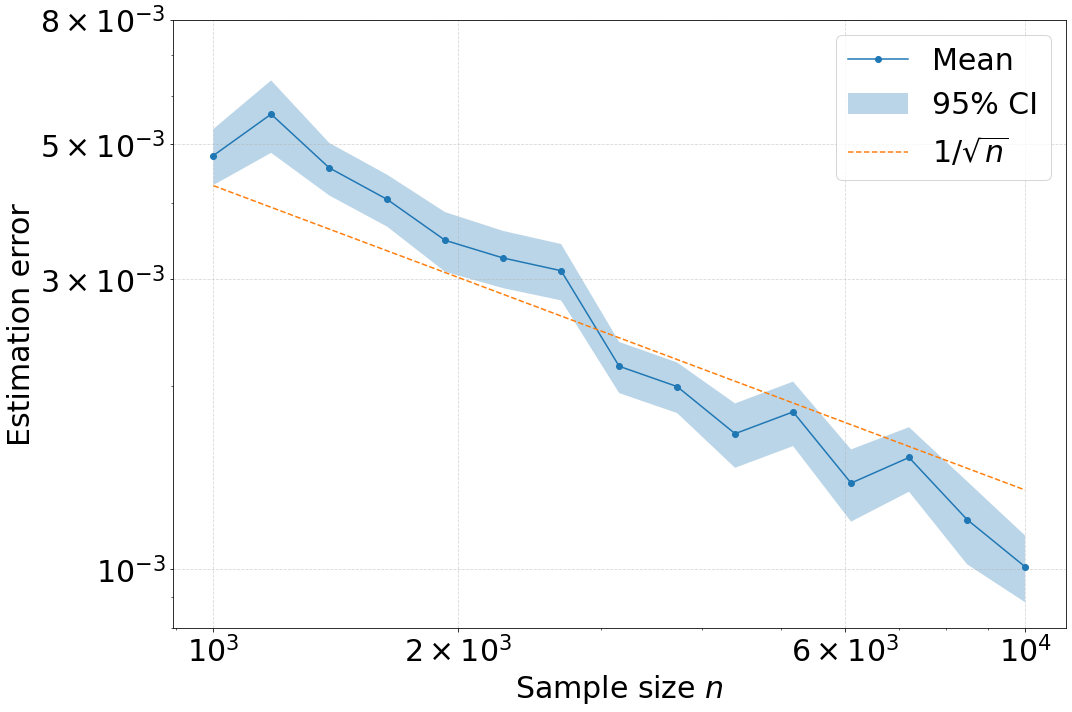

In [87]:
n_cols = [col for col in df2.columns if col.startswith("n=")]
n_points = np.array([int(col.split("=")[1]) for col in n_cols])
nb_exp=df2.shape[0]

# Matrice des W_all1
W_all2 = df2[n_cols].values  # shape (nb_exp, len(n_points))

# Vecteur FD_min_all1
FD_min_all2 = df2["FD_min"].values  # shape (nb_exp,)
# Plot
W_delta = W_all2 - FD_min_all2[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

plt.figure(figsize=(15, 10))
plt.plot(n_points, mean_curve, "-o", label="Mean")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% CI")
plt.plot(n_points, 0.135 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
yticks = [0.001,0.003, 0.005, 0.008]
ytick_labels = [r"$10^{-3}$",r"$3\times 10^{-3}$", r"$5\times10^{-3}$", r"$8\times10^{-3}$"]  # labels affichés
xticks=[1000,2000,6000,10000]
xticks_labels=[r"$10^3$",r"$2\times 10^{3}$",r"$6\times 10^{3}$",r"$10^4$"]
plt.yticks(yticks, ytick_labels,fontsize=30)
plt.xticks(xticks,xticks_labels,fontsize=30)
plt.legend(fontsize=30, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figure_N50.pdf", dpi=300)
plt.show()

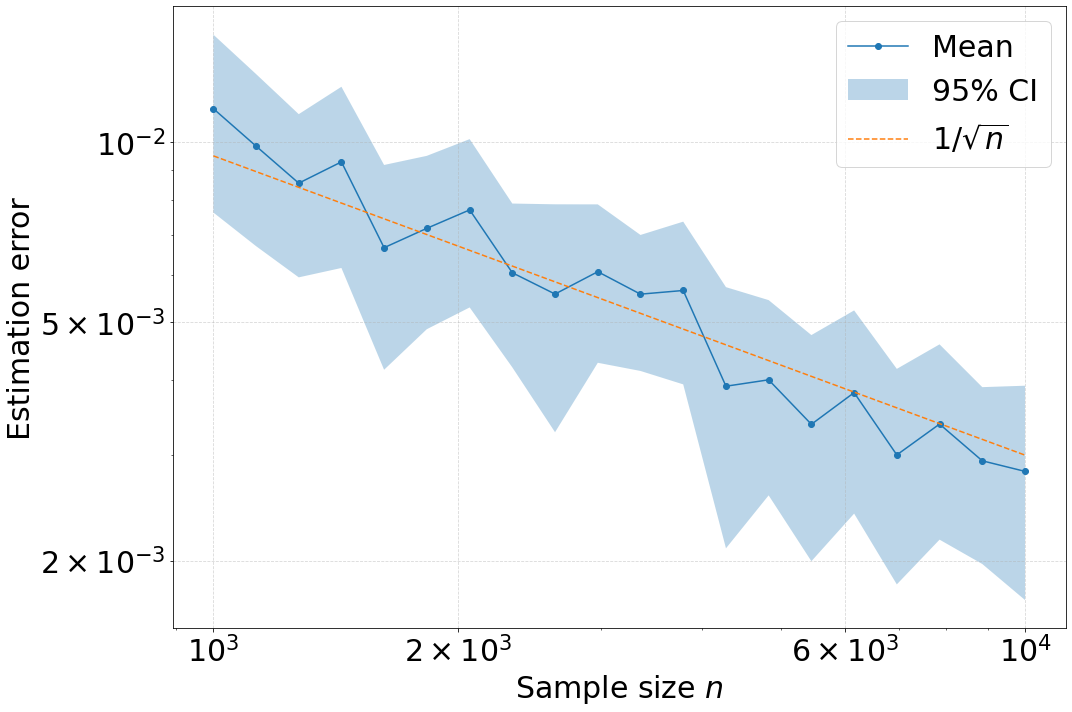

In [98]:
n_cols = [col for col in df3.columns if col.startswith("n=")]
n_points = np.array([int(col.split("=")[1]) for col in n_cols])
nb_exp=df5.shape[0]

# Matrice des W_all1
W_all3 = df5[n_cols].values  # shape (nb_exp, len(n_points))

# Vecteur FD_min_all1
FD_min_all3 = df5["FD_min"].values  # shape (nb_exp,)
# Plot
W_delta = W_all3 - FD_min_all3[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

plt.figure(figsize=(15, 10))
plt.plot(n_points, mean_curve, "-o", label="Mean")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% CI")
plt.plot(n_points, 0.3 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
yticks = [0.002, 0.005, 0.01]
ytick_labels = [r"$2\times 10^{-3}$", r"$5\times10^{-3}$",r"$10^{-2}$"]  # labels affichés
xticks=[1000,2000,6000,10000]
xticks_labels=[r"$10^3$",r"$2\times 10^{3}$",r"$6\times 10^{3}$",r"$10^4$"]
plt.yticks(yticks, ytick_labels,fontsize=30)
plt.xticks(xticks,xticks_labels,fontsize=30)
plt.legend(fontsize=30, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figure_N10reg.pdf", dpi=300)
plt.show()

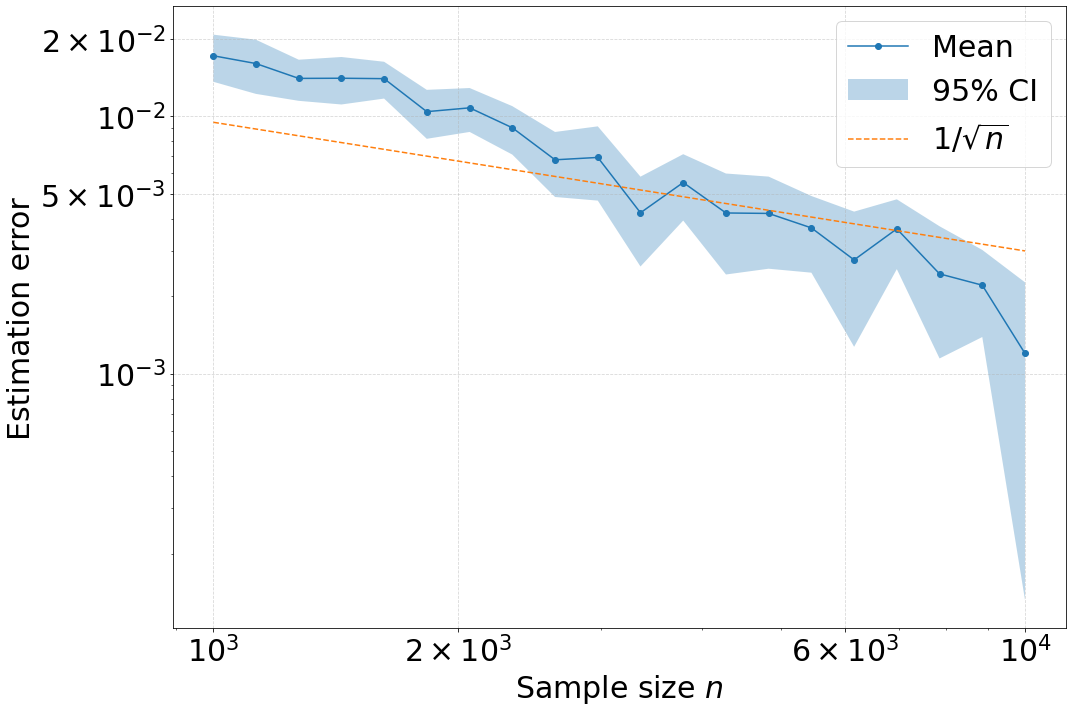

In [88]:
n_cols = [col for col in df4.columns if col.startswith("n=")]
n_points = np.array([int(col.split("=")[1]) for col in n_cols])
nb_exp=df4.shape[0]

# Matrice des W_all1
W_all4 = df4[n_cols].values  # shape (nb_exp, len(n_points))

# Vecteur FD_min_all1
FD_min_all4 = df4["FD_min"].values  # shape (nb_exp,)
# Plot
W_delta = W_all4 - FD_min_all4[:, None]

# Average + 95%IC
mean_curve = W_delta.mean(axis=0)
std_curve = W_delta.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)

plt.figure(figsize=(15, 10))
plt.plot(n_points, mean_curve, "-o", label="Mean")
plt.fill_between(n_points, low, up, alpha=0.3, label="95% CI")
plt.plot(n_points, 0.3 / np.sqrt(n_points), "--", label="$1/\\sqrt{n}$")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sample size $n$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
yticks = [0.001, 0.005, 0.01,0.02]
ytick_labels = [r"$10^{-3}$", r"$5\times10^{-3}$",r"$10^{-2}$",r"$2\times10^{-2}$"]  # labels affichés
xticks=[1000,2000,6000,10000]
xticks_labels=[r"$10^3$",r"$2\times 10^{3}$",r"$6\times 10^{3}$",r"$10^4$"]
plt.yticks(yticks, ytick_labels,fontsize=30)
plt.xticks(xticks,xticks_labels,fontsize=30)
plt.legend(fontsize=30, loc="upper right"); 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figure_N50reg.pdf", dpi=300)
plt.show()

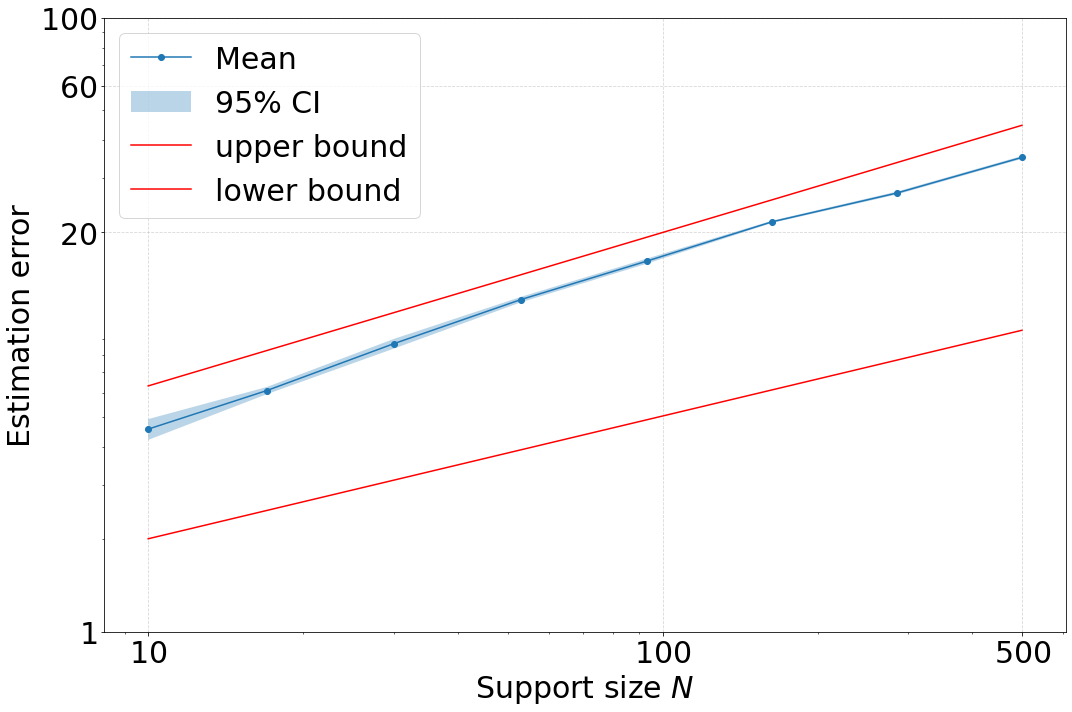

In [89]:
df = pd.read_csv("df_Nvaries.csv")


N_points = [int(c.split('=')[1]) for c in df.columns if c.startswith("N=")]
W_all = df[[f"N={N}" for N in N_points]].values
nb_exp = W_all.shape[0]


mean_curve = W_all.mean(axis=0)
std_curve = W_all.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)


plt.figure(figsize=(15, 10))
plt.plot(N_points, mean_curve, "-o", label="Mean")
plt.fill_between(N_points, low, up, alpha=0.3, label="95% CI")

dim = 20  
N_points = np.array(N_points)
plt.plot(N_points, 20*0.1*np.sqrt(N_points), color='red', label='upper bound')
plt.plot(N_points, 4*0.2*np.sqrt(N_points**(1-4/dim)), color='red', label='lower bound')

plt.xscale("log"); plt.yscale("log")

plt.xlabel("Support size $N$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
yticks = [1,20, 60, 100]
ytick_labels = [r"$1$",r"$20$", r"$60$", r"$100$"]  # labels affichés
xticks=[10,100,500]
xticks_labels=[r"$10$",r"$100$",r"$500$"]
plt.yticks(yticks, ytick_labels,fontsize=30)
plt.xticks(xticks,xticks_labels,fontsize=30)
plt.legend(fontsize=30, loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figure_Nvaries.pdf", dpi=300)

plt.show()


In [ ]:


N_points = [int(c.split('=')[1]) for c in df.columns if c.startswith("N=")]
W_all = df6[[f"N={N}" for N in N_points]].values
nb_exp = W_all.shape[0]


mean_curve = W_all.mean(axis=0)
std_curve = W_all.std(axis=0)
low = mean_curve - 1.96 * std_curve / np.sqrt(nb_exp)
up  = mean_curve + 1.96 * std_curve / np.sqrt(nb_exp)


plt.figure(figsize=(15, 10))

plt.plot(N_points, mean_curve, "-o", label="Mean")
plt.fill_between(N_points, low, up, alpha=0.3, label="95% CI")

dim = 20  
N_points = np.array(N_points)
plt.plot(N_points, 1.5*0.1*np.sqrt(N_points), color='red', label='upper bound')
plt.xlim(10, 500)
plt.ylim(0.4, 1.45)
plt.xscale("log"); plt.yscale("log")
yticks = [0.3,1,1.5,2]
ytick_labels = [r"$3\times10^{-1}$",r"$1$", r"$1.5\times10^{1}$", r"$2$"]  # labels affichés
xticks=[10,100,500]
xticks_labels=[r"$10$",r"$100$",r"$500$"]
plt.yticks(yticks, ytick_labels,fontsize=25)
plt.xticks(xticks,xticks_labels,fontsize=25)
ax = plt.gca()
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_locator(plt.NullLocator())
plt.xlabel("Support size $N$", fontsize=30)
plt.ylabel("Estimation error", fontsize=30)
plt.legend(fontsize=30, loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Figures_Nvaryreg.pdf", dpi=300)

plt.show()
